In [218]:
from src.efficientat.mn.model import get_model
import torch

model = get_model(182, 'mn20_as', width_mult=2., features_only=True, out_indices=(10,12,15,16))
x = torch.randn((2,1,128,384))
out, fs = model(x)

for f in fs:
    print(f.shape)

Features only is true, Dropping final fully-connected layer and loading weights in non-strict mode
torch.Size([2, 160, 8, 24])
torch.Size([2, 224, 8, 24])
torch.Size([2, 320, 4, 12])
torch.Size([2, 1920, 4, 12])


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchaudio
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython.display as ipd
from datetime import datetime
import time
import librosa
import ast
plt.style.use('ggplot')

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import default_collate
from torchvision.transforms import v2

import audiomentations
from glob import glob
from scipy import signal

In [3]:
save_dir = 'checkpoints/2024-05-31_18-20-02_128x384_mn20_as_fold-2'
checkpoint_name = f'{save_dir}/checkpoint.pth'
checkpoint = torch.load(checkpoint_name, map_location='cpu')

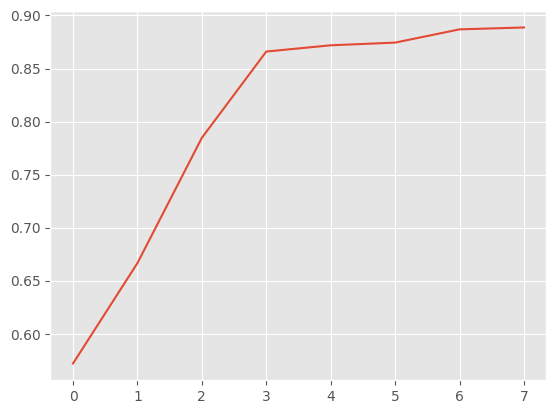

In [4]:
plt.plot(checkpoint['val_metrics']['AUC'])

In [2]:
# Utilities for displaying audio
def visualize_audio(waveform, sr, original=None):
    if isinstance(waveform, torch.Tensor):
        waveform = waveform.numpy()
    if len(waveform.shape) > 1:
        waveform = waveform[0]
    ipd.display(ipd.Audio(waveform, rate=sr))

    # Create subplots for audio visualizations
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    # Waveform
    if original is not None:
        if isinstance(original, torch.Tensor):
            original = original.numpy()
        if len(original.shape) > 1:
            original = original[0]
        axs[0].plot(original, alpha=0.4, label='Original')
    axs[0].plot(waveform, alpha=0.6, label='Augmented')
    axs[0].set_title('Waveform')
    if original is not None:
        axs[0].legend()

    # Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sr)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=sr, ax=axs[1])
    axs[1].set_title('Mel Spectrogram')
    
    
def visualize_spec(spec):
    plt.figure(figsize=(7,4))
    plt.imshow(spec[0], origin='lower', cmap='magma')
    plt.grid(visible=False)
    plt.title('Mel Spectrogram')
    plt.xlabel('Time step')
    plt.ylabel('Mel bin')
    plt.show()
    
    
def visualize_spec_batch(spec_batch):
    plt.figure(figsize=(14,8))
    for k in range(spec_batch.shape[0]):
        plt.subplot(4,4,k+1)
        plt.imshow(spec_batch[k,0].detach().cpu().numpy(), origin='lower', cmap='magma')
        plt.grid(visible=False)
    plt.tight_layout()
    plt.show()

In [6]:
64*2.5

160.0

In [7]:
32000*5/64

2500.0

In [29]:
class Config:
    start_idx = 'first'
    use_peaks = True
    peak_filter = 'gaussian'
    duration = 15
    sample_rate = 32000
    target_length = 500 #!!!!!!!!!!!!
    n_mels = 128 #!!!!!!!!!!!!!!!
    n_fft = 1024
    window = 160
    audio_len = duration*sample_rate
    hop_length = 64 if use_peaks else audio_len // (target_length-1)
    fmin = 50 #500
    fmax = 16000
    top_db = 80

    n_classes = 182
    n_channels = 1 #!!!!!!!!!!!
    
    use_openvino = True
    multithreading = False
    checkpoint_dir = '/kaggle/input/mn-20/other/2024-05-29_14-24-40_sed-128-384/1'
    loss = 'crossentropy'
    ensemble_checkpoints = ['/kaggle/input/mn-20/other/2024-05-29_10-17-54_att-128-384/1',
                            '/kaggle/input/mn-20/other/2024-05-29_08-53-40_att-128-500/1',
                            '/kaggle/input/mn-20/other/2024-05-29_14-24-40_sed-128-384/1',
                            '/kaggle/input/mn-20/other/2024-05-29_13-02-17_attms-128-384/1',
                            '/kaggle/input/mn-20/other/2024-05-29_11-40-04_gem-128-384/1',
                            '/kaggle/input/mn-20/other/2024-05-29_10-17-54_att-128-384/1',
                            '/kaggle/input/mn-20/other/2024-05-29_10-17-54_att-128-384/1',
                            '/kaggle/input/mn-20/other/2024-05-29_10-17-54_att-128-384/1',
                            '/kaggle/input/mn-20/other/2024-05-29_10-17-54_att-128-384/1',
                            '/kaggle/input/mn-20/other/2024-05-29_10-17-54_att-128-384/1'
                           ]
    ensemble_losses = ['crossentropy', 'crossentropy', 'crossentropy', 'crossentropy', 'crossentropy',
                       'crossentropy', 'crossentropy', 'crossentropy', 'crossentropy', 'crossentropy']

    standardize = False
    dataset_mean = [-16.8828]
    dataset_std = [12.4019]

In [14]:
def create_frames(waveform, duration=5, sr=32000):
    frame_size = int(duration * sr)
    surplus = waveform.size(-1)%frame_size
    if surplus > 0:
        waveform = waveform[:, :-surplus]
    frames = waveform.view(-1, 1, frame_size)
    return frames

class AudioDatasetInference(Dataset):
    def __init__(
            self, 
            files,
            targets = None, 
            n_classes = 182,
            duration = 15,
            sample_rate = 32000,
            target_length = 500,
            n_mels = 128,
            n_fft = 2028,
            window = 2028,
            hop_length = None,
            fmin = 20,
            fmax = 20000,
            top_db = 80,
            standardize=True,
            mean=None,
            std=None
            ):
        super(AudioDatasetInference, self).__init__()
        self.files = files
        self.targets = targets
        self.n_classes = n_classes
        self.duration = duration
        self.sample_rate = sample_rate
        self.audio_len = duration*sample_rate
        self.target_length = target_length
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.window = window
        self.hop_length = self.audio_len // (target_length-1) if not hop_length else hop_length
        self.fmin = fmin
        self.fmax = fmax
        self.top_db = top_db
        self.standardize = standardize

        self.to_mel_spectrogramn = nn.Sequential(
            torchaudio.transforms.MelSpectrogram(self.sample_rate, n_fft=self.n_fft, win_length=self.window,  
                                                 hop_length=self.hop_length, n_mels=self.n_mels, 
                                                 f_min=self.fmin, f_max=self.fmax),
            torchaudio.transforms.AmplitudeToDB(top_db=self.top_db)
        )
        if mean is not None:
            self.to_mel_spectrogramn.append(v2.Normalize(mean=mean, std=std))

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        if self.targets is not None:
            label = torch.tensor(self.targets[idx])

        file = self.files[idx]
        waveform, sr = torchaudio.load(file)
        frames = create_frames(waveform)
        spec = self.to_mel_spectrogramn(frames)
        # Standardize
        if self.standardize:
            spec = (spec - spec.mean()) / spec.std()

        # expand to 3 channels for imagenet trained models
        spec = spec.expand(-1,Config.n_channels,-1,-1)

        if self.targets is not None:
            return spec, label
        else:
            return spec, file

In [15]:
base_dir = 'data'
train_dir = base_dir + '/train_audio/'
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)
class_labels = list(range(n_classes))
label2name = dict(zip(class_labels, class_names))
name2label = {v:k for k,v in label2name.items()}

def get_label_from_name(name):
    if name not in name2label.keys():
        return None
    return name2label[name]

metadata = pd.read_csv(base_dir + '/train_metadata.csv')
metadata['filepath'] = train_dir + metadata.filename
metadata['target'] = metadata.primary_label.map(name2label)
metadata['secondary_targets'] = metadata.secondary_labels.map(lambda x: [get_label_from_name(name) for name in ast.literal_eval(x)])

In [75]:
# Truncated or pad the audio sample to the desired duration
def trunc_or_pad(waveform, audio_len, start_idx='random'):
    sig_len = waveform.shape[-1]
    diff_len = abs(sig_len - audio_len)

    if (sig_len > audio_len):
        # Truncate the signal to the given length
        if start_idx == 'random':
            start_idx = np.random.randint(0, diff_len)
        else:
            start_idx = 0
        waveform = waveform[:, start_idx:start_idx + audio_len]
    
    elif (sig_len < audio_len):
        # Length of padding to add at the beginning and end of the signal
        pad1 = np.random.randint(0, diff_len)
        pad2 = diff_len - pad1
        if isinstance(waveform, torch.Tensor):
            waveform = nn.functional.pad(waveform, pad=(pad1, pad2), mode='constant', value=0)
        else:
            waveform = np.pad(waveform, ((0, 0), (pad1, pad2)), mode='constant', constant_values=0)
    
    return waveform

file = metadata["filepath"][789]
waveform, sr = torchaudio.load(file)
waveform = trunc_or_pad(waveform, Config.audio_len, start_idx=Config.start_idx)
file, waveform.shape

('data/train_audio/barswa/XC327392.ogg', torch.Size([1, 480000]))

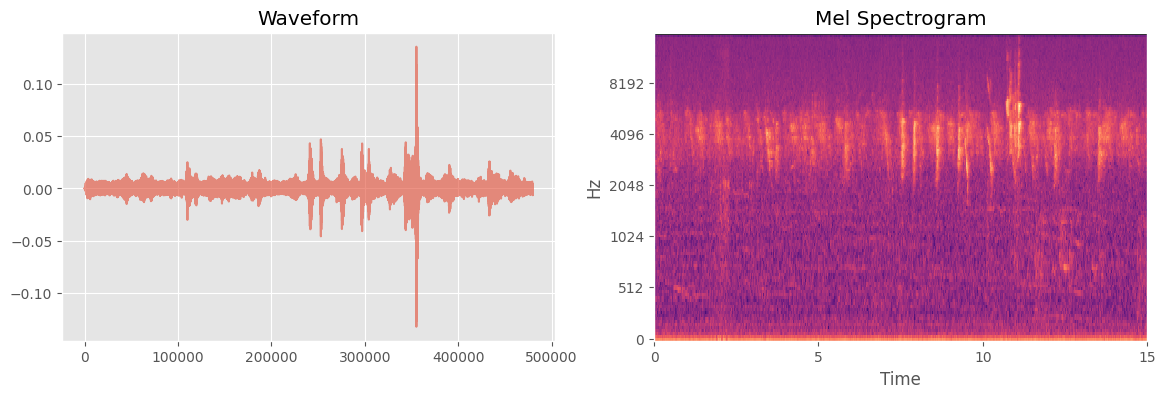

In [76]:
visualize_audio(waveform, sr)

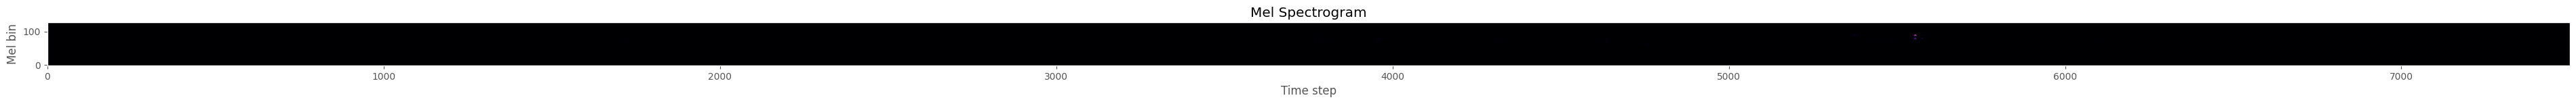

torch.Size([1, 128, 7501])

In [77]:
# Compute spectrogram
to_mel_spectrogramn = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(Config.sample_rate, n_fft=Config.n_fft, win_length=Config.window,  
                                         hop_length=Config.hop_length, n_mels=Config.n_mels, 
                                         f_min=Config.fmin, f_max=Config.fmax),
    #torchaudio.transforms.AmplitudeToDB(top_db=Config.top_db),
    #v2.Normalize(mean=Config.dataset_mean, std=Config.dataset_std)
)

spec = to_mel_spectrogramn(waveform)
spec.shape

plt.figure(figsize=(48,10))
plt.imshow(spec[0], origin='lower', cmap='magma')
plt.grid(visible=False)
plt.title('Mel Spectrogram')
plt.xlabel('Time step')
plt.ylabel('Mel bin')
plt.show()
spec.shape

In [78]:
per_frame_energy = spec.sum(dim=1).squeeze().numpy()
per_frame_energy.shape

(7501,)

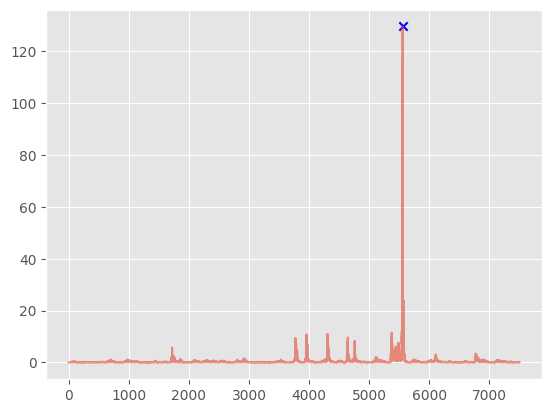

In [79]:
peak = per_frame_energy.argmax()
plt.plot(per_frame_energy, alpha=0.6)
plt.scatter([peak], per_frame_energy[peak], c='blue', marker='x')

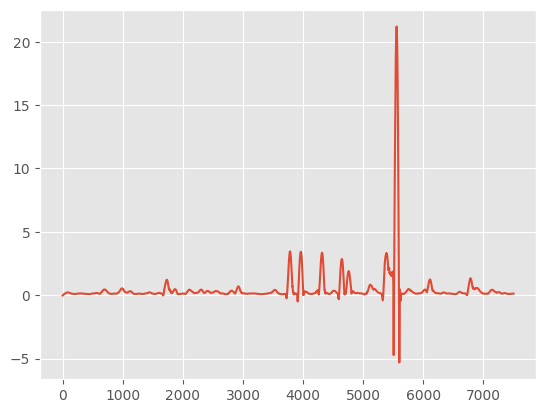

In [80]:
per_frame_energy_smooth = signal.savgol_filter(per_frame_energy, window_length=100, polyorder=2)
plt.plot(per_frame_energy_smooth)

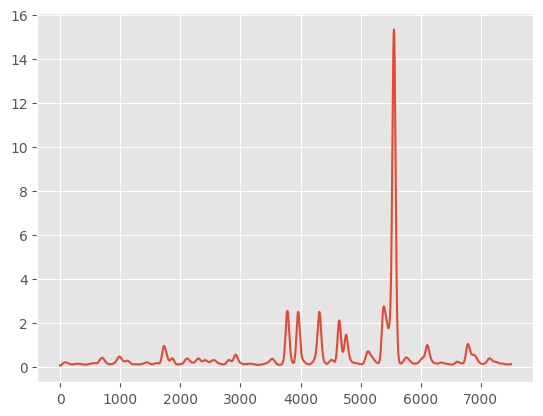

In [81]:
from scipy.ndimage import gaussian_filter1d
per_frame_energy_smooth_smooth = gaussian_filter1d(per_frame_energy, sigma=25)
plt.plot(per_frame_energy_smooth_smooth)

In [96]:
def find_peak_max(x, filter='savgol'):
    if filter == 'savgol':
        smooth_x = signal.savgol_filter(x, window_length=100, polyorder=2)
    elif filter == 'gaussian':
        smooth_x = gaussian_filter1d(x, sigma=25)
    else:
        smooth_x = x
    return smooth_x.argmax()

def find_peaks_max(x, filter='savgol', window=500, rel_threshold=0.5):
    if filter == 'savgol':
        smooth_x = signal.savgol_filter(x, window_length=100, polyorder=2)
    elif filter == 'gaussian':
        smooth_x = gaussian_filter1d(x, sigma=25)
    else:
        smooth_x = x
    
    main_peak = smooth_x.argmax()
    main_peak_value = smooth_x[main_peak]
    s1, s2 = window_around_peak(len(smooth_x), main_peak, window)
    smooth_x[s1:s2] = 0
    peak_2 = smooth_x.argmax()
    if smooth_x[peak_2] < rel_threshold*main_peak_value:
        return [main_peak]
    s1, s2 = window_around_peak(len(smooth_x), peak_2, window)
    smooth_x[s1:s2] = 0
    peak_3 = smooth_x.argmax()
    if smooth_x[peak_3] < rel_threshold*main_peak_value:
        return [main_peak, peak_2]
    return [main_peak, peak_2, peak_3]
    

def window_around_peak(len_x, peak, window_size):
    half_window = window_size // 2
    start_index = max(0, peak - half_window)
    end_index = min(len_x, peak + half_window)

    # Adjust the window if it's too close to the borders
    if end_index - start_index < window_size:
        if start_index == 0:
            end_index = min(len_x, start_index + window_size)
        elif end_index == len_x:
            start_index = max(0, end_index - window_size)
    return start_index, end_index

peak = find_peak_max(per_frame_energy, filter=Config.peak_filter)
peaks = find_peaks_max(per_frame_energy, filter=Config.peak_filter, window=Config.target_length, rel_threshold=0.25)

In [90]:
per_frame_energy_smooth_smooth[peaks[0]]

15.327372

In [91]:
np.mean(per_frame_energy_smooth_smooth)

0.5059776

In [95]:
15*0.3

4.5

In [93]:
0.5/15

0.03333333333333333

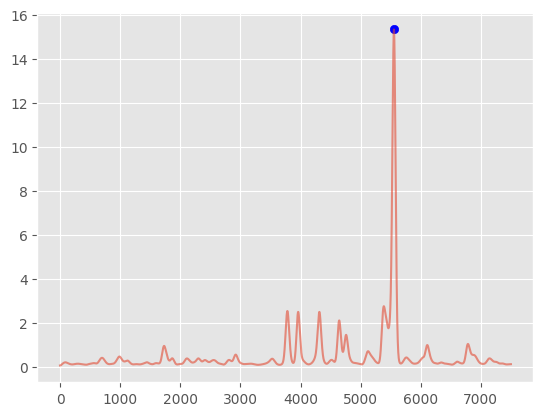

In [94]:
plt.plot(per_frame_energy_smooth_smooth, alpha=0.6)
plt.scatter(peaks, per_frame_energy_smooth_smooth[peaks], c='blue')

In [26]:
peaks = signal.find_peaks_cwt(per_frame_energy_smooth_smooth, np.arange(1,25))
peaks

array([   4,  446,  605,  705, 1116, 1730, 2024, 2243, 2474, 2572, 2661,
       2755, 2946, 3277, 3399, 3789, 3955, 4277, 4636, 4775, 4942, 5032,
       5398, 5466, 5534, 5601, 5829, 5953, 6070, 6306, 6383, 6491, 6592,
       6698, 6768, 6856, 7059, 7188, 7289, 7369, 7497])

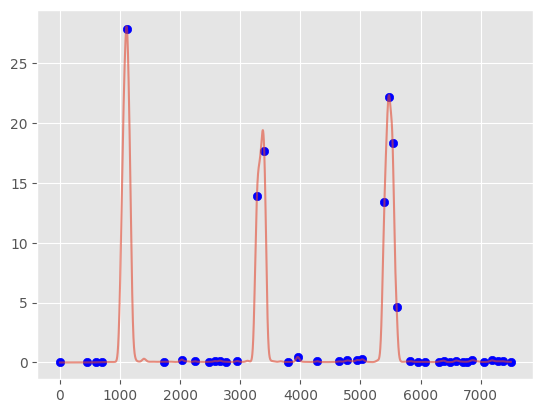

In [28]:
plt.plot(per_frame_energy_smooth_smooth, alpha=0.6)
plt.scatter(peaks, per_frame_energy_smooth_smooth[peaks], c='blue')

In [391]:
proms, _, _ = signal.peak_prominences(per_frame_energy_smooth, peaks)

/tmp/ipykernel_8249/1357641789.py:1: PeakPropertyWarning: some peaks have a prominence of 0
  proms, _, _ = signal.peak_prominences(per_frame_energy_smooth, peaks)


In [392]:
peaks[proms.argmax()]

759

In [215]:
width, width_heigths, _, _ = signal.peak_widths(per_frame_energy, peaks)

/tmp/ipykernel_8249/420422313.py:1: PeakPropertyWarning: some peaks have a prominence of 0
  width, width_heigths, _, _ = signal.peak_widths(per_frame_energy, peaks)
/tmp/ipykernel_8249/420422313.py:1: PeakPropertyWarning: some peaks have a width of 0
  width, width_heigths, _, _ = signal.peak_widths(per_frame_energy, peaks)


In [216]:
peaks[width.argmax()]

1231

In [190]:
width_heigths.argmax()

19